In [2]:
import plumed
import matplotlib
from matplotlib import pyplot as plt
import numpy as np
import MDAnalysis as md
from MDAnalysis.analysis import distances
import pandas as pd
import itertools
import random
from deeptime.decomposition import TICA
from deeptime.covariance import KoopmanWeightingEstimator
from deeptime.clustering import MiniBatchKMeans
from deeptime.markov import TransitionCountEstimator
from deeptime.markov.msm import MaximumLikelihoodMSM
from deeptime.markov.msm import BayesianMSM
from deeptime.plots import plot_implied_timescales
from deeptime.util.validation import implied_timescales
import networkx as nx
from copy import deepcopy
from numpy.random import multinomial
import subprocess
import os
import math
import string
from scipy.stats import pearsonr

import warnings
warnings.filterwarnings('ignore')
###############################USER DEFINE REGION##################################

### Environment
os.environ['PATH'] = '/usr/local/Climber:/usr/local/pymol:/usr/local/gromacs/bin:/usr/local/plumed/bin:/usr/local/openmpi/bin:/usr/local/cuda-12.2/bin:/usr/local/clash:/home/mingyuan/.local/bin:/usr/local/sbin:/usr/local/bin:/usr/sbin:/usr/bin:/sbin:/bin:/usr/games:/usr/local/games:/snap/bin:/snap/bin'
os.environ['LD_LIBRARY_PATH'] = '/usr/local/gromacs/lib:/usr/local/plumed/lib:/usr/local/libtorch/lib:/usr/local/openmpi/lib:/usr/local/cuda-12.2/lib64:'
os.environ['CPATH'] = '/usr/local/libtorch/include/torch:/usr/local/libtorch/include/:/usr/local/libtorch/include/torch/csrc/api/include/:'
os.environ['INCLUDE'] = '/usr/local/libtorch/include/torch:/usr/local/libtorch/include/:/usr/local/libtorch/include/torch/csrc/api/include/:'

### Hyperparameters
# Run setup
sim_name = 'ala10'
colvar = 'CV/COLVAR'
topol = 'traj_and_dat/input.pdb'
seed_ref = 'traj_and_dat/seed_ref.pdb'
n_sim = 16
n_steps = 2500000
# Progress control
n_rounds = 40
sim_idx = 11
# hardware-related
ntomp = 1
gpu_id = '0,1'
n_jobs = 32
# TICA parameters (for adaptive sampling)
tica_lagtime = 250
dim = None
var_cutoff = 0.95
koopman = True
# Implied time scale evaluation
its_lagtimes = [10,20,35,50,75,100,125,150]
tica_its_lagtimes = [10,20,35,50,75,100,125,150]
n_its = 5
# Markov State Model parameters
msm_lagtime = 250
# PCCA parameters
n_metastable_sets = 30
# CV machine learning & convergence check
convergence_check = True
num_cvs = 2
patience = 2
convergence_criteria = 0.99
# OPES parameters
barrier = 20
opes_steps = None

# Feature functions
def select_dihedrals(universe,dihedral_type,start_res,end_res):
    dihedrals={}
    for dih_type in ['phi','psi','omega']:
        if dih_type in dihedral_type:
            dihedrals[dih_type]=[]
            for i in range(start_res,end_res+1):
                if i != universe.residues.resids[-1]:  # Check if it is the last residue
                    dihedrals[dih_type].append(i)

    if 'chi1' in dihedral_type:
        dihedrals['chi1']=[]
        for i in range(start_res,end_res+1):
            count = i - universe.residues.resids[0]
            if universe.residues.resnames[count] not in ['GLY','ALA']:
                dihedrals['chi1'].append(i)

    if 'chi2' in dihedral_type:
        dihedrals['chi2']=[]
        for i in range(start_res,end_res+1):
            count = i - universe.residues.resids[0]
            if universe.residues.resnames[count] not in ['GLY','ALA','CYS','SER','THR','VAL']:
                dihedrals['chi2'].append(i)

    if 'chi3' in dihedral_type:
        dihedrals['chi3']=[]
        for i in range(start_res,end_res+1):
            count = i - universe.residues.resids[0]
            if universe.residues.resnames[count] in ['ARG','GLN','GLU','LYS','MET']:
                dihedrals['chi3'].append(i)

    if 'chi4' in dihedral_type:
        dihedrals['chi4']=[]
        for i in range(start_res,end_res+1):
            count = i - universe.residues.resids[0]
            if universe.residues.resnames[count] in ['ARG','LYS']:
                dihedrals['chi4'].append(i)
    return dihedrals
    
def write_features(colvar,sim_idx,n_sim,sim_name):
    idx_start = sim_idx * n_sim
    idx_end = (sim_idx+1) * n_sim - 1
    with open('features.sh','w+') as f:
        f.writelines('start={idx_start}\n'.format(idx_start=idx_start))
        f.writelines('end={idx_end}\n'.format(idx_end=idx_end))
        f.writelines('for i in `seq $start $end`\n')
        f.writelines('do\n')
        f.writelines('    cp $i/{sim_name}.xtc traj_and_dat/\n'.format(sim_name=sim_name))
        f.writelines('    mv traj_and_dat/{sim_name}.xtc traj_and_dat/$i.xtc\n'.format(sim_name=sim_name))
        f.writelines('    plumed driver --plumed traj_and_dat/features.dat --mf_xtc traj_and_dat/$i.xtc\n')
        f.writelines('    plumed driver --plumed traj_and_dat/ref.dat --mf_xtc traj_and_dat/$i.xtc\n')
        f.writelines('    mv COLVAR CV/COLVAR_$i\n')
        f.writelines('    mv COLVAR_ref CV/COLVAR_ref_$i\n')
        f.writelines('done\n')
    subprocess.run(['chmod u+x features.sh'], shell=True)
    subprocess.run(['./features.sh'], shell=True)
    return None

### Analysis functions
def read_features(colvar,sim_idx,n_sim):
    # traj is the time-series COLVAR in pandas.DataFrame format
    traj_idx = []
    for i in range(sim_idx*n_sim):
        traj_idx.append(i)
    
    no_traj = len(traj_idx)
    traj = [0]*no_traj
    
    for i in traj_idx:
        traj[i] = plumed.read_as_pandas(colvar+'_{i}'.format(i=i))
        traj[i] = traj[i].drop(columns=['time'])
        columns = list(traj[i].columns.values)
        # Remove all dihedral angles, only keep sin/cos dihedrals 
        for column in columns:
            if column[:3] == 'phi' or column[:3] == 'psi' or column[:3] == 'chi' or column[:5] == 'omega':
                traj[i] = traj[i].drop(columns=[column])
            
    # data is the time-series COLVAR in numpy.ndarrays format
    data = [0]*len(traj)
    for i in range(len(traj)):
        numpy_data = traj[i].to_numpy(dtype='float32')
        data[i] = numpy_data
            
    return traj,data

def data_supplement(sim_idx,data,lagtime):
    round_seed_idx = []

    for i in range(1,sim_idx):
        round_seed_idx_i = np.loadtxt('round{i}_seed.txt'.format(i=i),dtype=int)
        round_seed_idx.append(round_seed_idx_i)

    round_seed_idx = np.concatenate(round_seed_idx)

    data_supp = []

    for i,round_seed_idx_i in enumerate(round_seed_idx):
    
        sim_i = round_seed_idx_i[0]
        frame = round_seed_idx_i[1]
    
        if frame == 0:
            continue
        elif lagtime > frame:
            start_frame = 0
        else:
            start_frame = frame - lagtime + 1
    
        end_frame = lagtime
    
        data_supp_pre = data[sim_i][start_frame:frame,:]
        data_supp_post = data[i][:end_frame,:]
        data_supp_i = np.concatenate([data_supp_pre,data_supp_post])
    
        data_supp.append(data_supp_i)
    
    return data_supp
    
def run_TICA(data,data_supp,lagtime,dim=None,var_cutoff=None,koopman=True):
    data_syn = data + data_supp
    tica = TICA(lagtime=lagtime,dim=dim,var_cutoff=var_cutoff)
    if koopman == True:
        koopman_estimator = KoopmanWeightingEstimator(lagtime=lagtime)
        reweighting_model = koopman_estimator.fit(data_syn).fetch_model()
        tica = tica.fit(data_syn, weights=reweighting_model).fetch_model()
    else:
        tica = tica.fit(data_syn).fetch_model()
    # tica is the data-fitted model, which contains eigenvalues and eigenvectors
    # tica_output is the tranformed time-series data in TICA space in shape(traj_idx,no_frames,dim)
    # tica_output_concat is tica_output in shape(traj_idx*no_frames,dim)
    tica_output = tica.transform(data)
    tica_output_concat = np.concatenate(tica_output)

    tica_output_supp = []
    for data_supp_i in data_supp:
        tica_output_supp_i = tica.transform(data_supp_i)
        tica_output_supp.append(tica_output_supp_i)
        
    return tica,tica_output,tica_output_concat,tica_output_supp

def calculate_nmicro(data_concat):
    # Heuristic approach to determine cluster number from htmd 
    # https://github.com/Acellera/htmd/blob/master/htmd/adaptive/adaptivebandit.py
    n_microstates = int(max(100, np.round(0.6 * np.log10(data_concat.shape[0] / 1000) * 1000 + 50)))
    return n_microstates
    
def run_kmeans(tica_output,tica_output_supp,tica_output_concat,n_microstates,n_jobs):
    minibatch_kmeans = MiniBatchKMeans(n_clusters=n_microstates,batch_size=10000,max_iter=100,init_strategy='kmeans++',n_jobs=n_jobs)
    microstates = minibatch_kmeans.fit(tica_output_concat).fetch_model()
    cluster_centers = microstates.cluster_centers
    # assignments_concat is the microstate assignment in shape (traj_idx*no_frames,)
    # assignments is the microstate assignment in shape (traj_idx,no_frames)
    assignments_concat = microstates.transform(tica_output_concat)
    assignments = assignments_concat.reshape(-1,tica_output.shape[1])

    assignments_supp = []
    for tica_output_supp_i in tica_output_supp:
        assignments_supp_i = microstates.transform(tica_output_supp_i)
        assignments_supp.append(assignments_supp_i)
    
    return assignments,assignments_concat,cluster_centers,assignments_supp

def evaluate_its(lagtimes,n_its,sim_idx,assignments,assignments_supp):
    assignments_syn = list(assignments) + assignments_supp
    models = []
    for lagtime in lagtimes:
        counts = TransitionCountEstimator(lagtime=lagtime, count_mode='sliding').fit_fetch(assignments_syn)
        models.append(MaximumLikelihoodMSM().fit_fetch(counts))
    its_data = implied_timescales(models)
    fig, ax = plt.subplots(1, 1)
    plot_implied_timescales(its_data, n_its=n_its, ax=ax)
    ax.set_yscale('log')
    ax.set_xlabel('Lagtime (steps)')
    ax.set_ylabel('Implied Timescale (steps)')
    plt.savefig('figures/its-{sim_idx}.png'.format(sim_idx=sim_idx),dpi=600)
    return None

def evaluate_tica_its(tica_its_lagtimes,dim,var_cutoff,koopman,n_its,sim_idx,data,data_supp):
    tica_models = []
    for lag in tica_its_lagtimes:
        tica = run_TICA(data,data_supp,lag,dim,var_cutoff,koopman)[0]
        tica_models.append(tica)
    its_data = implied_timescales(tica_models)
    fig, ax = plt.subplots(1, 1)
    plot_implied_timescales(its_data, n_its=n_its, ax=ax)
    ax.set_yscale('log')
    ax.set_title('Implied timescales')
    ax.set_xlabel('lag time (steps)')
    ax.set_ylabel('timescale (steps)')
    ax.set_xticks(tica_its_lagtimes)
    plt.savefig('figures/tica-its-{sim_idx}.png'.format(sim_idx=sim_idx),dpi=600)
    return None
    
def build_Bayesian_MSM(msm_lagtime,assignments,assignments_supp):
    assignments_syn = list(assignments) + assignments_supp
    counts = TransitionCountEstimator(lagtime=msm_lagtime, count_mode='effective').fit_fetch(assignments_syn)
    msm = BayesianMSM().fit_fetch(counts)
    return counts,msm

def build_MLE_MSM(msm_lagtime,assignments,assignments_supp):
    assignments_syn = list(assignments) + assignments_supp
    counts = TransitionCountEstimator(lagtime=msm_lagtime, count_mode='sliding').fit_fetch(assignments_syn)
    msm = MaximumLikelihoodMSM().fit_fetch(counts)
    return counts,msm
    
def run_PCCA(msm,n_metastable_sets):
    pcca = msm.pcca(n_metastable_sets=n_metastable_sets)
    return pcca

### Adaptive seeding functions
def fix_disconnected(counts,n_microstates,msm,pcca):
    ### Locate the connected and disconnected sets:
    sets = counts.connected_sets(connectivity_threshold=0,directed=True,sort_by_population=True)
    disconnected_sets = sets[1:]
    n_macro_disconnected = len(disconnected_sets)
    disconnected_dict = {}
    for i in range(n_macro_disconnected):
        macro_label = n_metastable_sets + i
        for j in disconnected_sets[i]:
            disconnected_dict[j] = macro_label

    # We need to modify:
    # 1. pcca.assignments: assign each disconnected microstate to a new pseudo-macrostate
    # 2. msm.stationary_distribution: insert 0 at the location corresponding to the disconnected microstates
    pcca_assignments = np.zeros(n_microstates,dtype=int)
    stationary_distribution = np.zeros(n_microstates,)

    connected_count = 0
    for i in range(n_microstates):
        if i in disconnected_dict.keys():
            pcca_assignments[i] = disconnected_dict[i]
            stationary_distribution[i] = 0
        else:
            pcca_assignments[i] = pcca.assignments[connected_count]
            stationary_distribution[i] = msm.stationary_distribution[connected_count]
            connected_count += 1
        
    return n_macro_disconnected,pcca_assignments,stationary_distribution
    
    
def count_macro(n_sim,n_macro_disconnected,pcca_assignments,assignments,assignments_concat,sim_idx):
    # Obtain macrostate assignment to original time-series data
    macro_assignments = dict(enumerate(pcca_assignments))
    macro_timeseries = np.vectorize(macro_assignments.get)(assignments_concat)
    
    # Macrostate seeding
    unique_macro, counts_macro = np.unique(macro_timeseries, return_counts=True)
    prob_macro = (1 / counts_macro) / np.sum(1 / counts_macro)
    macrostate_seed = multinomial(n_sim,prob_macro)

    # Microstate seeding
    # First count the occurences of all microstates
    unique_micro, counts_micro = np.unique(assignments_concat, return_counts=True)
    seed_idx = []
    counts_micro_i_log = {}
    for macro_i, n_sample in enumerate(macrostate_seed):
        # locate the index of microstates not assigned to current selected macrostates
        not_macro_idx = np.where(pcca_assignments != np.unique(pcca_assignments)[macro_i])
        # let all entries corresponding to not_macro_idx = 0, therefore ignore them during selection
        counts_micro_i = deepcopy(counts_micro)
        counts_micro_i[not_macro_idx] = 0
        # let 1/0 = 0
        inverse_counts = np.where(counts_micro_i==0, 0, 1/counts_micro_i)
        prob_micro_i = inverse_counts / np.sum(inverse_counts)
        microstate_seed = multinomial(n_sample,prob_micro_i)
        # Record selection statistics for visualization
        if n_sample != 0:
            macro_idx_log = unique_macro[macro_i] 
            counts_micro_i_log[macro_idx_log] = [counts_micro_i,microstate_seed]
        for micro_i, n_sample in enumerate(microstate_seed):
            seed_idx = seed_idx + n_sample * [micro_i]

    conf_seed = []

    for i,seed in enumerate(seed_idx):
        conf_idx = np.array(np.where(assignments==seed)).T
        conf_seed_frame = conf_idx[np.random.randint(conf_idx.shape[0], size=1), :][0]
        conf_seed.append(conf_seed_frame)

    # Visualization
    n_macro_nodes = n_metastable_sets + n_macro_disconnected
    labels = {}
    color_map = []
    node_size = []

    G = nx.Graph()

    # label and color for origin
    labels[0] = assignments_concat.shape[0]
    color_map.append('red')

    # label,color,node size
    for i,macro_idx in enumerate(unique_macro):
        seed_counts_i = macrostate_seed[i]
        labels[macro_idx+1] = str(counts_macro[i])+',{seed_counts_i}'.format(seed_counts_i=seed_counts_i)
        if seed_counts_i != 0:
            color_map.append('orange')
        else:
            color_map.append('blue')
        G.add_edge(0,macro_idx+1)

    for macro_i,micro_counts_seed in counts_micro_i_log.items():
        index = np.where(micro_counts_seed[0] != 0)
        for idx in index[0]:
            if idx <= n_macro_nodes:
                G.add_edge(macro_i+1,idx+10000)
                labels[idx+10000] = str(micro_counts_seed[0][idx])+','+str(micro_counts_seed[1][idx])
            else:
                G.add_edge(macro_i+1,idx)
                labels[idx] = str(micro_counts_seed[0][idx])+','+str(micro_counts_seed[1][idx])
            if micro_counts_seed[1][idx] != 0:
                color_map.append('green')
            else:
                color_map.append('blue')

    for i,node in enumerate(G):
        node_size.append(1000)

    # get positions
    pos = nx.spring_layout(G)

    # shift position a little bit
    shift = [0.1, 0]
    shifted_pos ={node: node_pos + shift for node, node_pos in pos.items()}

    # adjust size
    fig,ax = plt.subplots(figsize=(14,14))
    #ax.set_xlim([1*x for x in axis.get_xlim()])
    #ax.set_ylim([1*y for y in axis.get_ylim()])

    # draw graph
    nx.draw(G, pos, with_labels=True,font_color='white',node_color=color_map,node_size=node_size)

    # draw labels
    nx.draw_networkx_labels(G, shifted_pos, labels=labels, horizontalalignment="left")

    # turn off frame
    ax.axis("off")
    # Save figure
    plt.savefig('figures/Visualize_Count_Macro_{sim_idx}.png'.format(sim_idx=sim_idx),dpi=600)
        
    return conf_seed
    
    
def write_gmxfile(sim_idx,n_sim,seed_ref,conf_seed):
    ### .gro seed files generation
    u_list = []
    for i in range(sim_idx*n_sim):
        u_traj = md.Universe(seed_ref,'traj_and_dat/{i}.xtc'.format(i=i))
        u_list.append(u_traj)

    for i,seed in enumerate(conf_seed):
        traj_no = seed[0]
        frame = seed[1]
        u_list[traj_no].atoms.write('{i}.gro'.format(i=i+sim_idx*n_sim),frames=u_list[traj_no].trajectory[frame:frame+1])

    np.savetxt('round{sim_idx}_seed.txt'.format(sim_idx=sim_idx),conf_seed,fmt='%s')
        
    idx_start = sim_idx * n_sim
    idx_end = (sim_idx + 1) * n_sim - 1
        
    with open('grompp.sh','w+') as f:
        f.writelines('start={idx_start}\n'.format(idx_start=idx_start))
        f.writelines('end={idx_end}\n'.format(idx_end=idx_end))
        f.writelines('for i in `seq $start $end`\n')
        f.writelines('do\n')
        f.writelines('    mkdir $i\n')
        f.writelines('    gmx grompp -f ../mdp/md.mdp -p ../1-topol/topol.top -c $i.gro -o {sim_name}.tpr\n'.format(sim_name=sim_name))
        f.writelines('    mv {sim_name}.tpr $i\n'.format(sim_name=sim_name))
        f.writelines('done\n')
    subprocess.run(['chmod u+x grompp.sh'], shell=True)
    subprocess.run(['./grompp.sh'], shell=True)
        
    return None

### Machine learning CV related functions
def cv_ref_projection(): # TODO: print figures which project tica eigenvectors on 2d ref surface 
    return

def calculate_cv_sigma(tica_output_concat,num_cvs):
    sigma = np.zeros(num_cvs,)
    for i in range(num_cvs):
        sigma[i] = np.std(tica_output_concat.T[i])
    return sigma
    
def cv_convergence(data,tica_lagtime,num_cvs,tica_cv_models,sim_idx):
    '''
    # Split data to retrieve dataset at each round
    data_split = []
    for sim_i in range(1,sim_idx+1):
        data_sim_i = data[:(sim_i*n_sim)]
        data_split.append(data_sim_i)
    '''
    # We use all TICA models learnt to transform current dataset
    tica_outputs = []

    for tica_i in tica_cv_models:
        tica_output_concat_i = np.concatenate(tica_i.transform(data))
        tica_outputs.append(tica_output_concat_i)

    # Stack all transformation into a 3d array with shape (model_no,frame_no,num_cvs)
    tica_outputs = np.stack(tica_outputs)

    # Check convergence with Pearson correlation
    correlations = np.zeros((tica_outputs.shape[0]-1,num_cvs))
    
    for i in range(tica_outputs.shape[0]-1):
        for j in range(num_cvs):
            correlation = pearsonr(tica_outputs[i,:,j].T,tica_outputs[-1,:,j].T)[0]
            correlations[i][j] = np.abs(correlation)

    return correlations

def tica_plumed(barrier,feature_dat,traj,tica,num_cvs,sigma):
    traj_concat = pd.concat(traj,axis=0)
    with open('opes/plumed.dat','w+') as f:
        f.writelines('MOLINFO STRUCTURE=input.pdb\n')
        with open(feature_dat,'r') as g:
            lines = g.readlines()
            for line in lines[1:-1]:   # remove PRINT argument
                f.writelines(line)
        arg_string = ''
        parameters_string = ''
        for feature in traj_concat.columns:
            arg_string = arg_string + feature + ','
            mean = np.mean(traj_concat[feature])
            parameters_string = parameters_string + str(mean) + ','
        arg_string = arg_string[:-1]
        parameters_string = parameters_string[:-1]
        for i in range(num_cvs):
            coeff_string = ''
            for value in tica.singular_vectors_left.T[i]:
                string = str(value)+','
                coeff_string = coeff_string + string
            coeff_string = coeff_string[:-1]
            f.writelines('tica{i}: COMBINE ARG={arg_string} COEFFICIENTS={coeff_string} PARAMETERS={parameters_string} PERIODIC=NO\n'.format(i=i,arg_string=arg_string,coeff_string=coeff_string,parameters_string=parameters_string))
        for feature in traj_concat.columns:
            arg_string = arg_string + feature + ','
        arg_string = arg_string[:-1]

        ####
        f.writelines('phi: TORSION ATOMS=@phi-2\n')
        f.writelines('phi: TORSION ATOMS=@psi-2\n')
        ####
        
        f.writelines('opes: OPES_METAD ...\n')
        opes_arg = ''
        for i in range(num_cvs):
            opes_arg = opes_arg + 'tica{i}'.format(i=i) + ','
        opes_arg = opes_arg[:-1]
        f.writelines('    ARG={opes_arg}\n'.format(opes_arg=opes_arg))
        f.writelines('    PACE=500 BARRIER={barrier}\n'.format(barrier=barrier))
        sigma_string = ''
        for i in range(num_cvs):
            sigma_string = sigma_string + str(sigma[i]) + ','
        sigma_string = sigma_string[:-1]
        f.writelines('    SIGMA={sigma_string}\n'.format(sigma_string=sigma_string))
        f.writelines('    STATE_RFILE=../STATE\n')
        f.writelines('    STATE_WFILE=../STATE\n')
        f.writelines('    NLIST\n')
        f.writelines('    WALKERS_MPI\n')
        f.writelines('...\n')
        f.writelines('PRINT ARG=phi,psi,{opes_arg},opes.* STRIDE=500 FILE=COLVAR'.format(opes_arg=opes_arg))
        
    subprocess.run(['cp traj_and_dat/input.pdb opes/'], shell=True)

    return None

# OPES related
def opes_seed(tica_output,tica_output_concat,tica_output_supp,n_sim,n_jobs,sim_idx,seed_ref):
    # 2D clustering
    assignments,assignments_concat,cluster_centers,assignments_supp = run_kmeans(tica_output,tica_output_supp,tica_output_concat,n_sim,n_jobs)
    
    # Visualization
    fig,ax = plt.subplots()
    sc = ax.scatter(tica_output_concat[:,0],tica_output_concat[:,1],c=assignments_concat)
    plt.plot(cluster_centers[:,0],cluster_centers[:,1],'o',ms=4,color='red')
    plt.colorbar(sc,label='cluster')
    plt.xlabel('kTICA IC1 $\phi_1$')
    plt.ylabel('kTICA IC2 $\phi_2$')
    plt.savefig('figures/OPES_seed.png',dpi=600)
    
    # Seeding
    opes_seed_idx = []
    
    for i in range(n_sim):
        dist_to_center_i = np.linalg.norm(tica_output - cluster_centers[i],axis=2)
        opes_seed_idx_i = np.array([np.where(dist_to_center_i == dist_to_center_i.min())[0][0],np.where(dist_to_center_i == dist_to_center_i.min())[1][0]])
        opes_seed_idx.append(opes_seed_idx_i)

    u_list = []
    for i in range(sim_idx*n_sim):
        u_traj = md.Universe(seed_ref,'traj_and_dat/{i}.xtc'.format(i=i))
        u_list.append(u_traj)

    for i,seed in enumerate(opes_seed_idx):
        traj_no = seed[0]
        frame = seed[1]
        u_list[traj_no].atoms.write('opes/{i}.gro'.format(i=i),frames=u_list[traj_no].trajectory[frame:frame+1])

    np.savetxt('opes/opes_seed.txt',opes_seed_idx,fmt='%s')
    
    return None

##### 800ns Adaptive Sampling Alone

In [3]:
traj,data = read_features(colvar,sim_idx,n_sim)
if sim_idx != 1:
    data_supp = data_supplement(sim_idx,data,tica_lagtime)

In [4]:
data[0].shape,len(data)

((501, 81), 176)

In [5]:
# final ktica
tica,tica_output,tica_output_concat,tica_output_supp = run_TICA(data,data_supp,tica_lagtime,dim,var_cutoff,koopman)

In [6]:
# Kinetic content
(tica.singular_values[:2]**2).sum()/(tica.singular_values**2).sum()

0.3614344501703273

In [7]:
# Ref data
ref_df = [0] * n_sim * sim_idx
for i in range(len(ref_df)):
    ref_df[i] = plumed.read_as_pandas('CV/COLVAR_ref_{i}'.format(i=i))
ref_data = pd.concat(ref_df)

In [8]:
ref_data.shape

(88176, 5)

In [9]:
n_microstates = 100

assignments,assignments_concat,cluster_centers,assignments_supp = run_kmeans(tica_output,tica_output_supp,tica_output_concat,n_microstates,n_jobs)

In [10]:
# Markov State Model Validation

n_its = 2
its_lagtimes = [1,5,10,20,30,40,50,60,70,80,90,100,125,150,175,200,225,250,275,300,325,350,375,400,425,450]

msm_lagtime = 250

converged_its = 500
n_space = 10
n_metastable_sets = 3

ns_per_step = 0.01

# ITS
models = []
for lagtime in its_lagtimes:
    assignments_fit = list(assignments) + assignments_supp
    counts = TransitionCountEstimator(lagtime=lagtime, count_mode='effective').fit_fetch(assignments_fit)
    models.append(BayesianMSM().fit_fetch(counts))
its_data = implied_timescales(models)


# MSM
counts,msm = build_Bayesian_MSM(msm_lagtime,assignments,assignments_supp)

# cktest
models = []
lagtimes = np.linspace(msm_lagtime,converged_its,n_space,dtype=int)
for lagtime in lagtimes:
    assignments_fit = list(assignments) + assignments_supp
    counts = TransitionCountEstimator(lagtime=lagtime, count_mode='effective').fit_fetch(assignments_fit)
    models.append(BayesianMSM().fit_fetch(counts))
ck_test = msm.ck_test(models,n_metastable_sets=n_metastable_sets)

Skipping state set [0] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [54] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [1] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [69] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [11] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [98] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [94] due to error in estimation: Some row and corresponding column of the count matrix C have zero counts..
Skipping state set [43] due to error in estimation: Some row and corresponding column of the count matrix C have 

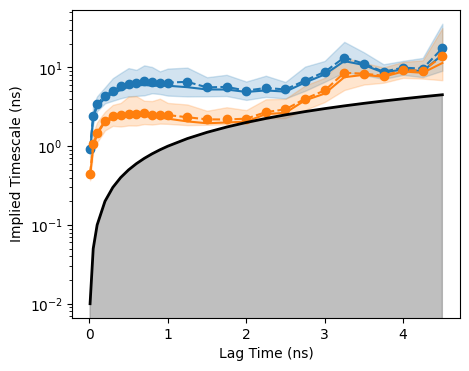

In [11]:
from deeptime.plots.util import default_colors
from deeptime.util import confidence_interval

fig, ax = plt.subplots(figsize=(5,4))

colors = default_colors()

for i in range(n_its):
    color = colors[i % len(colors)]
    ax.plot(its_data.lagtimes * ns_per_step, its_data.timescales_for_process(i) * ns_per_step,color=color)
    its_samples = its_data.samples_for_process(i)
    sample_mean = np.nanmean(its_samples, axis=1)
    ax.plot(its_data.lagtimes * ns_per_step, sample_mean * ns_per_step, marker='o', linestyle='dashed',color=color)
    l_conf, r_conf = confidence_interval(its_samples.T, conf=0.95, remove_nans=True)
    ax.fill_between(its_data.lagtimes * ns_per_step, l_conf * ns_per_step, r_conf * ns_per_step, alpha=0.2,color=color)
    
ax.plot(its_data.lagtimes * ns_per_step, its_data.lagtimes * ns_per_step, linewidth=2, color='black')
ax.fill_between(its_data.lagtimes * ns_per_step, np.full((its_data.n_lagtimes,), fill_value=ax.get_ylim()[0]), its_data.lagtimes * ns_per_step,
                alpha=0.5, color='grey')

ax.set_yscale('log')
ax.set_xlabel('Lag Time (ns)')
ax.set_ylabel('Implied Timescale (ns)')

plt.savefig('figures/adaptive_its.png',dpi=600)

In [12]:
confidences_pred_l = []
confidences_pred_r = []

conf = 0.95

samples = ck_test.predictions_samples

any_complex = np.any(~np.isreal(ck_test.estimates)) or np.any(~np.isreal(ck_test.predictions))

confidences_est_l = []
confidences_est_r = []
confidences_pred_l = []
confidences_pred_r = []

if ck_test.has_errors:
    samples = ck_test.predictions_samples
    for lag_samples in samples:
        any_complex |= np.any(~np.isreal(lag_samples))
        l_pred, r_pred = confidence_interval(np.real(lag_samples) if not any_complex
                                             else [x.real for x in lag_samples],
                                             conf=conf, remove_nans=True)
        confidences_pred_l.append(l_pred)
        confidences_pred_r.append(r_pred)

    samples = ck_test.estimates_samples
    for lag_samples in samples:
        any_complex |= np.any(~np.isreal(lag_samples))
        l_est, r_est = confidence_interval(np.real(lag_samples) if not any_complex
                                           else [x.real for x in lag_samples],
                                           conf=conf, remove_nans=True)
        confidences_est_l.append(l_est)
        confidences_est_r.append(r_est)

if any_complex:
    warnings.warn("Your CKtest contains imaginary components which are ignored during plotting.",
                  category=np.ComplexWarning)

confidences = [confidences_est_l, confidences_est_r, confidences_pred_l, confidences_pred_r]
confidences = [np.array(conf) for conf in confidences]
l_est, r_est, l_pred, r_pred = confidences

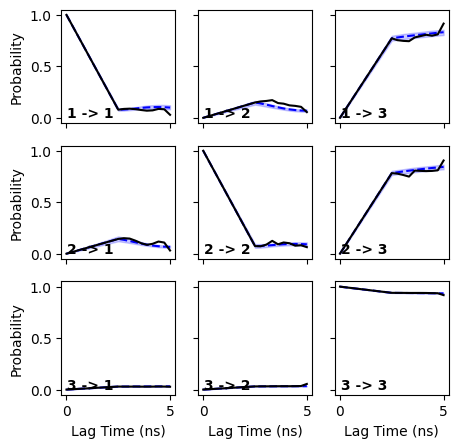

In [13]:
# cktest plot
fig,ax = plt.subplots(nrows=ck_test.n_components,ncols=ck_test.n_components,sharex=True,sharey=True,figsize=(5,5))
for i in range(ck_test.n_components):
    for j in range(ck_test.n_components):
        ax[i,j].plot(ck_test.lagtimes * ns_per_step, ck_test.predictions[:,i,j],color='blue',linestyle='dashed')
        ax[i,j].plot(ck_test.lagtimes * ns_per_step, ck_test.estimates[:,i,j],color='black')
        ax[i,j].fill_between(ck_test.lagtimes * ns_per_step , l_pred[:, i, j].real, r_pred[:, i, j].real, color='blue', alpha=0.2)
        #ax[i,j].set_xlim((ck_test.lagtimes * ns_per_step).min(),(ck_test.lagtimes * ns_per_step).max())
        #ax[i,j].set_ylim(0,1)
        if i == 2:
            ax[i,j].set_xlabel('Lag Time (ns)')
        if j == 0:
            ax[i,j].set_ylabel('Probability')
        ax[i,j].text(0.05, 0.05, str(i + 1) + ' -> ' + str(j + 1), transform=ax[i,j].transAxes, weight='bold')

plt.savefig('figures/adaptive-cktest.png',dpi=600)

In [14]:
# Load FES from converged KTICA-OPES as reference
fes_1d = {}
colvar_name = ['tica0','tica1','alpha','e2e']
xlabel_name = [r'KTICA tIC1 $\hat \psi_1$',r'KTICA tIC2 $\hat \psi_2$',r'ALPHARMSD $R_\alpha$',r'End-to-End Distance $d_{e2e}$ (nm)']
grid_max = []
grid_min = []

for cv in colvar_name:
    fes_1d[cv] = plumed.read_as_pandas('opes/final_COLVAR/hist-fes1/fes-{cv}_9.dat'.format(cv=cv))
    grid_max.append(fes_1d[cv][cv].max())
    grid_min.append(fes_1d[cv][cv].min())

fes_error = []
block_no = 5

for cv in colvar_name:
    fes_err_i = np.loadtxt('opes/final_COLVAR/1_error/err_fes_{cv}_{block_no}'.format(cv=cv,block_no=block_no))
    fes_error.append(fes_err_i)

In [15]:
grid_max,grid_min

([2.466289, 1.415158, 4.999998, 3.044425],
 [-1.311981, -1.261227, 0.005659, 0.341104])

In [16]:
tica_output_concat.shape

(88176, 32)

In [17]:
# Ref data
ref_df = [0] * n_sim * sim_idx
for i in range(len(ref_df)):
    ref_df[i] = plumed.read_as_pandas('CV/COLVAR_ref_{i}'.format(i=i))
ref_data = pd.concat(ref_df)

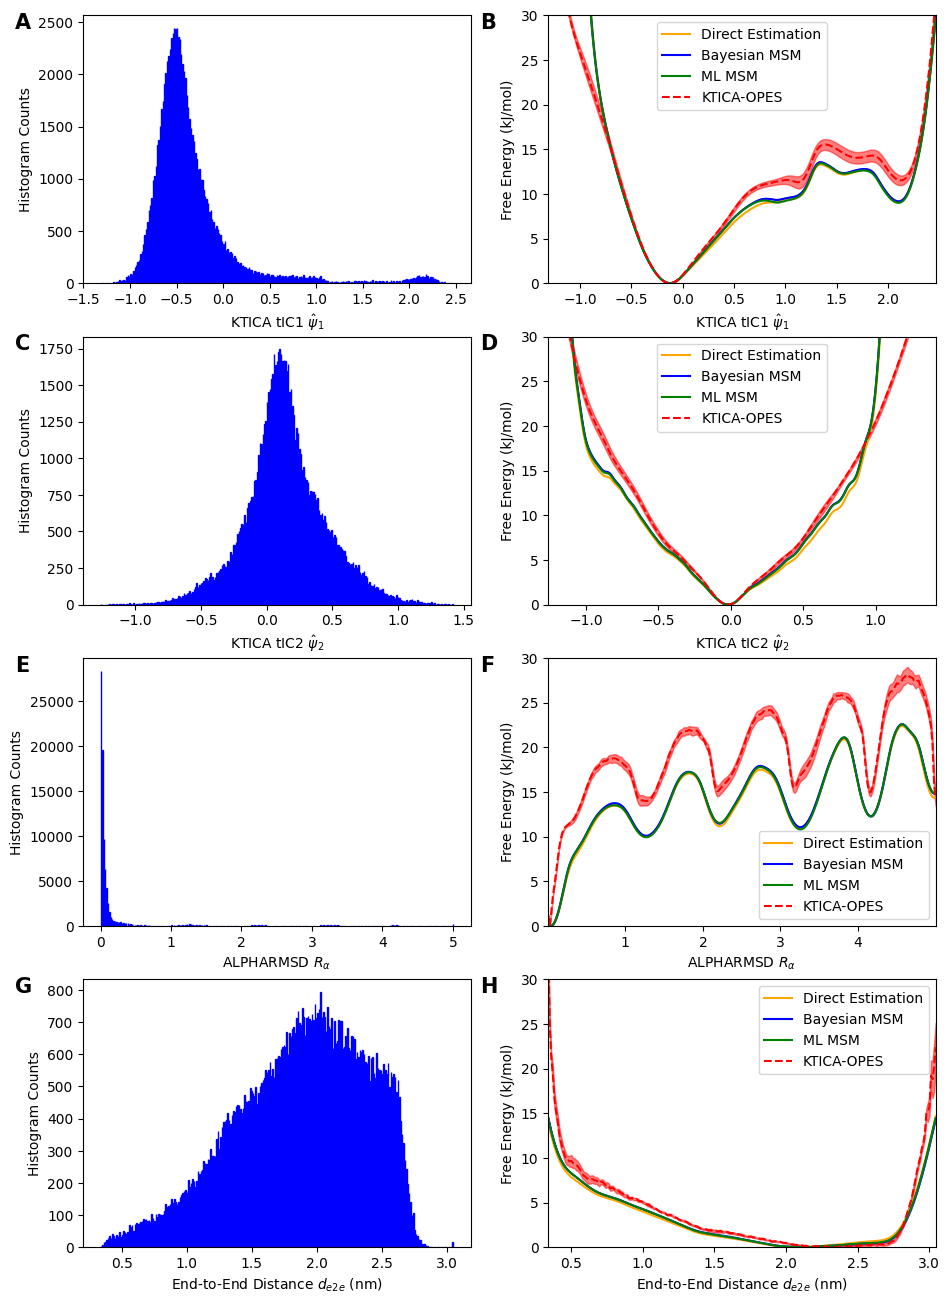

In [18]:
from scipy.stats import gaussian_kde
index_x = -0.175
index_y = 0.95


temperature = 310


msm_lagtime = 250

fig,ax = plt.subplots(nrows=4,ncols=2,figsize=(11,16))

### tIC1
# plot density first
i = 0
cv = 'tica0'

sigma = 'silverman'

x_grid = np.linspace(grid_min[i],grid_max[i],251)
histogram_count, edge = np.histogram(tica_output_concat[:,0],251)
density = histogram_count / histogram_count.sum()
ax[i,0].bar(x_grid,histogram_count,edgecolor='blue',width=0.005)
ax[i,0].set_xlabel(xlabel_name[i])
ax[i,0].set_ylabel('Histogram Counts')

# Adaptive Sampling FES without reweighting
kde = gaussian_kde(tica_output_concat[:,0],sigma)

free_energy = -8.314*temperature/1000*np.log(kde.pdf(x_grid))
free_energy = free_energy-free_energy.min()
ax[i,1].plot(x_grid,free_energy,label='Direct Estimation',color='orange')

# MSM-reweighted adaptive sampling FES

counts,msm = build_Bayesian_MSM(msm_lagtime,assignments,assignments_supp)
counts,msm_mle = build_MLE_MSM(msm_lagtime,assignments,assignments_supp)

unique_micro, count_micro = np.unique(assignments,return_counts=True)

# Bayesian MSM reweighted FES, with s.t.d. of sampled MSM as error
free_energy_all = []

for msm_i in msm.samples:
    assignments_weight_i = (msm_i.stationary_distribution / count_micro) / (msm_i.stationary_distribution / count_micro).sum()
    assignments_weights_i = dict(enumerate(assignments_weight_i))
    trajectory_weights_i = np.vectorize(assignments_weights_i.get)(assignments_concat)
    kde_i = gaussian_kde(tica_output_concat[:,0],sigma,weights=trajectory_weights_i)
    free_energy_i = -8.314*temperature/1000*np.log(kde_i.pdf(x_grid))
    free_energy_i = free_energy_i-free_energy_i.min()
    free_energy_all.append(free_energy_i)

free_energy_mean = np.mean(free_energy_all,axis=0)
free_energy_err = np.std(free_energy_all,axis=0) / np.sqrt(len(free_energy_all))

# ML MSM, without error estimation
assignments_weight = (msm_mle.stationary_distribution / count_micro) / (msm_mle.stationary_distribution / count_micro).sum()
assignments_weights = dict(enumerate(assignments_weight))
trajectory_weights = np.vectorize(assignments_weights.get)(assignments_concat)

kde = gaussian_kde(tica_output_concat[:,0],sigma,weights=trajectory_weights)
free_energy = -8.314*temperature/1000*np.log(kde.pdf(x_grid))
free_energy = free_energy-free_energy.min()

ax[i,1].plot(x_grid,free_energy_mean,label='Bayesian MSM',color='blue')
ax[i,1].fill_between(x_grid,free_energy_mean-free_energy_err, free_energy_mean+free_energy_err, color='blue', alpha=0.5)
ax[i,1].plot(x_grid,free_energy,label='ML MSM',color='green')

# Reference FES from 250ns OPES simulation
ax[i,1].plot(fes_1d[cv][cv],fes_1d[cv]['file.free'],'r--',label='KTICA-OPES')
ax[i,1].fill_between(x_grid,fes_1d[cv]['file.free']-fes_error[i], fes_1d[cv]['file.free']+fes_error[i], color='red', alpha=0.5)

ax[i,1].set_ylim(0,30)
ax[i,1].set_xlim(grid_min[i],grid_max[i])
ax[i,1].set_xlabel(xlabel_name[i])
ax[i,1].set_ylabel('Free Energy (kJ/mol)')
ax[i,1].legend()


### tIC2
# plot density first
i = 1
cv = 'tica1'

sigma = 'silverman'

x_grid = np.linspace(grid_min[i],grid_max[i],251)
histogram_count, edge = np.histogram(tica_output_concat[:,1],251)
density = histogram_count / histogram_count.sum()
ax[i,0].bar(x_grid,histogram_count,edgecolor='blue',width=0.005)
ax[i,0].set_xlabel(xlabel_name[i])
ax[i,0].set_ylabel('Histogram Counts')

# Adaptive Sampling FES without reweighting
kde = gaussian_kde(tica_output_concat[:,1],sigma)

free_energy = -8.314*temperature/1000*np.log(kde.pdf(x_grid))
free_energy = free_energy-free_energy.min()
ax[i,1].plot(x_grid,free_energy,label='Direct Estimation',color='orange')

# MSM-reweighted adaptive sampling FES

counts,msm = build_Bayesian_MSM(msm_lagtime,assignments,assignments_supp)
counts,msm_mle = build_MLE_MSM(msm_lagtime,assignments,assignments_supp)

unique_micro, count_micro = np.unique(assignments,return_counts=True)

# Bayesian MSM reweighted FES, with s.t.d. of sampled MSM as error
free_energy_all = []

for msm_i in msm.samples:
    assignments_weight_i = (msm_i.stationary_distribution / count_micro) / (msm_i.stationary_distribution / count_micro).sum()
    assignments_weights_i = dict(enumerate(assignments_weight_i))
    trajectory_weights_i = np.vectorize(assignments_weights_i.get)(assignments_concat)
    kde_i = gaussian_kde(tica_output_concat[:,1],sigma,weights=trajectory_weights_i)
    free_energy_i = -8.314*temperature/1000*np.log(kde_i.pdf(x_grid))
    free_energy_i = free_energy_i-free_energy_i.min()
    free_energy_all.append(free_energy_i)

free_energy_mean = np.mean(free_energy_all,axis=0)
free_energy_err = np.std(free_energy_all,axis=0) / np.sqrt(len(free_energy_all))

# ML MSM, without error estimation
assignments_weight = (msm_mle.stationary_distribution / count_micro) / (msm_mle.stationary_distribution / count_micro).sum()
assignments_weights = dict(enumerate(assignments_weight))
trajectory_weights = np.vectorize(assignments_weights.get)(assignments_concat)

kde = gaussian_kde(tica_output_concat[:,1],sigma,weights=trajectory_weights)
free_energy = -8.314*temperature/1000*np.log(kde.pdf(x_grid))
free_energy = free_energy-free_energy.min()

ax[i,1].plot(x_grid,free_energy_mean,label='Bayesian MSM',color='blue')
ax[i,1].fill_between(x_grid,free_energy_mean-free_energy_err, free_energy_mean+free_energy_err, color='blue', alpha=0.5)
ax[i,1].plot(x_grid,free_energy,label='ML MSM',color='green')

# Reference FES from 250ns OPES simulation
ax[i,1].plot(fes_1d[cv][cv],fes_1d[cv]['file.free'],'r--',label='KTICA-OPES')
ax[i,1].fill_between(x_grid,fes_1d[cv]['file.free']-fes_error[i], fes_1d[cv]['file.free']+fes_error[i], color='red', alpha=0.5)

ax[i,1].set_ylim(0,30)
ax[i,1].set_xlim(grid_min[i],grid_max[i])
ax[i,1].set_xlabel(xlabel_name[i])
ax[i,1].set_ylabel('Free Energy (kJ/mol)')
ax[i,1].legend()

### ALPHARMSD
# plot density first
i = 2
cv = 'alpha'

sigma = 'silverman'

x_grid = np.linspace(grid_min[i],grid_max[i],251)
histogram_count, edge = np.histogram(ref_data[cv],251)
density = histogram_count / histogram_count.sum()
ax[i,0].bar(x_grid,histogram_count,edgecolor='blue',width=0.005)
ax[i,0].set_xlabel(xlabel_name[i])
ax[i,0].set_ylabel('Histogram Counts')

# Adaptive Sampling FES without reweighting
kde = gaussian_kde(ref_data[cv],sigma)

free_energy = -8.314*temperature/1000*np.log(kde.pdf(x_grid))
free_energy = free_energy-free_energy.min()
ax[i,1].plot(x_grid,free_energy,label='Direct Estimation',color='orange')

# MSM-reweighted adaptive sampling FES

counts,msm = build_Bayesian_MSM(msm_lagtime,assignments,assignments_supp)
counts,msm_mle = build_MLE_MSM(msm_lagtime,assignments,assignments_supp)

unique_micro, count_micro = np.unique(assignments,return_counts=True)

# Bayesian MSM reweighted FES, with s.t.d. of sampled MSM as error
free_energy_all = []

for msm_i in msm.samples:
    assignments_weight_i = (msm_i.stationary_distribution / count_micro) / (msm_i.stationary_distribution / count_micro).sum()
    assignments_weights_i = dict(enumerate(assignments_weight_i))
    trajectory_weights_i = np.vectorize(assignments_weights_i.get)(assignments_concat)
    kde_i = gaussian_kde(ref_data[cv],sigma,weights=trajectory_weights_i)
    free_energy_i = -8.314*temperature/1000*np.log(kde_i.pdf(x_grid))
    free_energy_i = free_energy_i-free_energy_i.min()
    free_energy_all.append(free_energy_i)

free_energy_mean = np.mean(free_energy_all,axis=0)
free_energy_err = np.std(free_energy_all,axis=0) / np.sqrt(len(free_energy_all))

# ML MSM, without error estimation
assignments_weight = (msm_mle.stationary_distribution / count_micro) / (msm_mle.stationary_distribution / count_micro).sum()
assignments_weights = dict(enumerate(assignments_weight))
trajectory_weights = np.vectorize(assignments_weights.get)(assignments_concat)

kde = gaussian_kde(ref_data[cv],sigma,weights=trajectory_weights)
free_energy = -8.314*temperature/1000*np.log(kde.pdf(x_grid))
free_energy = free_energy-free_energy.min()

ax[i,1].plot(x_grid,free_energy_mean,label='Bayesian MSM',color='blue')
ax[i,1].fill_between(x_grid,free_energy_mean-free_energy_err, free_energy_mean+free_energy_err, color='blue', alpha=0.5)
ax[i,1].plot(x_grid,free_energy,label='ML MSM',color='green')

# Reference FES from 250ns OPES simulation
ax[i,1].plot(fes_1d[cv][cv],fes_1d[cv]['file.free'],'r--',label='KTICA-OPES')
ax[i,1].fill_between(x_grid,fes_1d[cv]['file.free']-fes_error[i], fes_1d[cv]['file.free']+fes_error[i], color='red', alpha=0.5)

ax[i,1].set_ylim(0,30)
ax[i,1].set_xlim(grid_min[i],grid_max[i])
ax[i,1].set_xlabel(xlabel_name[i])
ax[i,1].set_ylabel('Free Energy (kJ/mol)')
ax[i,1].legend()

### ALPHARMSD
# plot density first
i = 3
cv = 'e2e'

sigma = 'silverman'

x_grid = np.linspace(grid_min[i],grid_max[i],251)
histogram_count, edge = np.histogram(ref_data[cv],251)
density = histogram_count / histogram_count.sum()
ax[i,0].bar(x_grid,histogram_count,edgecolor='blue',width=0.005)
ax[i,0].set_xlabel(xlabel_name[i])
ax[i,0].set_ylabel('Histogram Counts')

# Adaptive Sampling FES without reweighting
kde = gaussian_kde(ref_data[cv],sigma)

free_energy = -8.314*temperature/1000*np.log(kde.pdf(x_grid))
free_energy = free_energy-free_energy.min()
ax[i,1].plot(x_grid,free_energy,label='Direct Estimation',color='orange')

# MSM-reweighted adaptive sampling FES

counts,msm = build_Bayesian_MSM(msm_lagtime,assignments,assignments_supp)
counts,msm_mle = build_MLE_MSM(msm_lagtime,assignments,assignments_supp)

unique_micro, count_micro = np.unique(assignments,return_counts=True)

# Bayesian MSM reweighted FES, with s.t.d. of sampled MSM as error
free_energy_all = []

for msm_i in msm.samples:
    assignments_weight_i = (msm_i.stationary_distribution / count_micro) / (msm_i.stationary_distribution / count_micro).sum()
    assignments_weights_i = dict(enumerate(assignments_weight_i))
    trajectory_weights_i = np.vectorize(assignments_weights_i.get)(assignments_concat)
    kde_i = gaussian_kde(ref_data[cv],sigma,weights=trajectory_weights_i)
    free_energy_i = -8.314*temperature/1000*np.log(kde_i.pdf(x_grid))
    free_energy_i = free_energy_i-free_energy_i.min()
    free_energy_all.append(free_energy_i)

free_energy_mean = np.mean(free_energy_all,axis=0)
free_energy_err = np.std(free_energy_all,axis=0) / np.sqrt(len(free_energy_all))

# ML MSM, without error estimation
assignments_weight = (msm_mle.stationary_distribution / count_micro) / (msm_mle.stationary_distribution / count_micro).sum()
assignments_weights = dict(enumerate(assignments_weight))
trajectory_weights = np.vectorize(assignments_weights.get)(assignments_concat)

kde = gaussian_kde(ref_data[cv],sigma,weights=trajectory_weights)
free_energy = -8.314*temperature/1000*np.log(kde.pdf(x_grid))
free_energy = free_energy-free_energy.min()

ax[i,1].plot(x_grid,free_energy_mean,label='Bayesian MSM',color='blue')
ax[i,1].fill_between(x_grid,free_energy_mean-free_energy_err, free_energy_mean+free_energy_err, color='blue', alpha=0.5)
ax[i,1].plot(x_grid,free_energy,label='ML MSM',color='green')

# Reference FES from 250ns OPES simulation
ax[i,1].plot(fes_1d[cv][cv],fes_1d[cv]['file.free'],'r--',label='KTICA-OPES')
ax[i,1].fill_between(x_grid,fes_1d[cv]['file.free']-fes_error[i], fes_1d[cv]['file.free']+fes_error[i], color='red', alpha=0.5)

ax[i,1].set_ylim(0,30)
ax[i,1].set_xlim(grid_min[i],grid_max[i])
ax[i,1].set_xlabel(xlabel_name[i])
ax[i,1].set_ylabel('Free Energy (kJ/mol)')
ax[i,1].legend()

ax[0,0].text(index_x, index_y, string.ascii_uppercase[0],transform=ax[0,0].transAxes, size=15, weight='bold')
ax[0,1].text(index_x, index_y, string.ascii_uppercase[1],transform=ax[0,1].transAxes, size=15, weight='bold')
ax[1,0].text(index_x, index_y, string.ascii_uppercase[2],transform=ax[1,0].transAxes, size=15, weight='bold')
ax[1,1].text(index_x, index_y, string.ascii_uppercase[3],transform=ax[1,1].transAxes, size=15, weight='bold')
ax[2,0].text(index_x, index_y, string.ascii_uppercase[4],transform=ax[2,0].transAxes, size=15, weight='bold')
ax[2,1].text(index_x, index_y, string.ascii_uppercase[5],transform=ax[2,1].transAxes, size=15, weight='bold')
ax[3,0].text(index_x, index_y, string.ascii_uppercase[6],transform=ax[3,0].transAxes, size=15, weight='bold')
ax[3,1].text(index_x, index_y, string.ascii_uppercase[7],transform=ax[3,1].transAxes, size=15, weight='bold')

plt.savefig('figures/adaptive_sampling_FES.png',dpi=600)

plt.show()

##### 4$\mu$s Adaptive Sampling using 10x longer trajectories

In [19]:
colvar = '../6-adaptive-50ns/CV/COLVAR'
n_sim = 16
sim_idx = 5

traj,data = read_features(colvar,sim_idx,n_sim)

round_seed_idx = []

for i in range(1,sim_idx):
    round_seed_idx_i = np.loadtxt('../6-adaptive-50ns/round{i}_seed.txt'.format(i=i),dtype=int)
    round_seed_idx.append(round_seed_idx_i)

round_seed_idx = np.concatenate(round_seed_idx)

data_supp = []        # We did not apply data supplementation when using the common adaptive sampling + MSM pipeline

In [20]:
# final ktica
tica,tica_output,tica_output_concat,tica_output_supp = run_TICA(data,data_supp,tica_lagtime,dim,var_cutoff,koopman)

In [21]:
# Ref data
ref_df = [0] * n_sim * sim_idx
for i in range(len(ref_df)):
    ref_df[i] = plumed.read_as_pandas('../6-adaptive-50ns/CV/COLVAR_ref_{i}'.format(i=i))
ref_data = pd.concat(ref_df)

In [22]:
ref_data.shape

(400080, 5)

In [23]:
n_microstates = 100

assignments,assignments_concat,cluster_centers,assignments_supp = run_kmeans(tica_output,tica_output_supp,tica_output_concat,n_microstates,n_jobs)

In [24]:
# Markov State Model Validation

n_its = 2
its_lagtimes = [1,5,10,20,30,40,50,60,70,80,90,100,125,150,175,200,225,250,275,300,325,350,375,400,425,450]

msm_lagtime = 250

converged_its = 2500
n_space = 10
n_metastable_sets = 2

ns_per_step = 0.01

# ITS
models = []
for lagtime in its_lagtimes:
    assignments_fit = list(assignments) + assignments_supp
    counts = TransitionCountEstimator(lagtime=lagtime, count_mode='effective').fit_fetch(assignments_fit)
    models.append(BayesianMSM().fit_fetch(counts))
its_data = implied_timescales(models)


# MSM
counts,msm = build_Bayesian_MSM(msm_lagtime,assignments,assignments_supp)

# cktest
models = []
lagtimes = np.linspace(msm_lagtime,converged_its,n_space,dtype=int)
for lagtime in lagtimes:
    assignments_fit = list(assignments) + assignments_supp
    counts = TransitionCountEstimator(lagtime=lagtime, count_mode='effective').fit_fetch(assignments_fit)
    models.append(BayesianMSM().fit_fetch(counts))
ck_test = msm.ck_test(models,n_metastable_sets=n_metastable_sets)

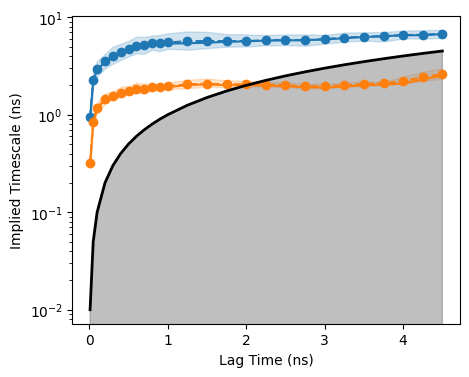

In [25]:
from deeptime.plots.util import default_colors
from deeptime.util import confidence_interval

fig, ax = plt.subplots(figsize=(5,4))

colors = default_colors()

for i in range(n_its):
    color = colors[i % len(colors)]
    ax.plot(its_data.lagtimes * ns_per_step, its_data.timescales_for_process(i) * ns_per_step,color=color)
    its_samples = its_data.samples_for_process(i)
    sample_mean = np.nanmean(its_samples, axis=1)
    ax.plot(its_data.lagtimes * ns_per_step, sample_mean * ns_per_step, marker='o', linestyle='dashed',color=color)
    l_conf, r_conf = confidence_interval(its_samples.T, conf=0.95, remove_nans=True)
    ax.fill_between(its_data.lagtimes * ns_per_step, l_conf * ns_per_step, r_conf * ns_per_step, alpha=0.2,color=color)
    
ax.plot(its_data.lagtimes * ns_per_step, its_data.lagtimes * ns_per_step, linewidth=2, color='black')
ax.fill_between(its_data.lagtimes * ns_per_step, np.full((its_data.n_lagtimes,), fill_value=ax.get_ylim()[0]), its_data.lagtimes * ns_per_step,
                alpha=0.5, color='grey')

ax.set_yscale('log')
ax.set_xlabel('Lag Time (ns)')
ax.set_ylabel('Implied Timescale (ns)')

plt.savefig('figures/adaptive_its50ns.png',dpi=600)

In [26]:
confidences_pred_l = []
confidences_pred_r = []

conf = 0.95

samples = ck_test.predictions_samples

any_complex = np.any(~np.isreal(ck_test.estimates)) or np.any(~np.isreal(ck_test.predictions))

confidences_est_l = []
confidences_est_r = []
confidences_pred_l = []
confidences_pred_r = []

if ck_test.has_errors:
    samples = ck_test.predictions_samples
    for lag_samples in samples:
        any_complex |= np.any(~np.isreal(lag_samples))
        l_pred, r_pred = confidence_interval(np.real(lag_samples) if not any_complex
                                             else [x.real for x in lag_samples],
                                             conf=conf, remove_nans=True)
        confidences_pred_l.append(l_pred)
        confidences_pred_r.append(r_pred)

    samples = ck_test.estimates_samples
    for lag_samples in samples:
        any_complex |= np.any(~np.isreal(lag_samples))
        l_est, r_est = confidence_interval(np.real(lag_samples) if not any_complex
                                           else [x.real for x in lag_samples],
                                           conf=conf, remove_nans=True)
        confidences_est_l.append(l_est)
        confidences_est_r.append(r_est)

if any_complex:
    warnings.warn("Your CKtest contains imaginary components which are ignored during plotting.",
                  category=np.ComplexWarning)

confidences = [confidences_est_l, confidences_est_r, confidences_pred_l, confidences_pred_r]
confidences = [np.array(conf) for conf in confidences]
l_est, r_est, l_pred, r_pred = confidences

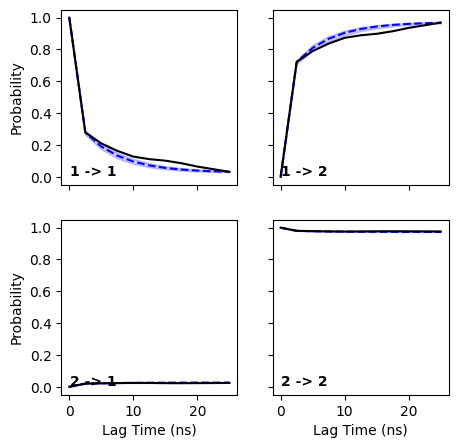

In [27]:
# cktest plot
fig,ax = plt.subplots(nrows=ck_test.n_components,ncols=ck_test.n_components,sharex=True,sharey=True,figsize=(5,5))
for i in range(ck_test.n_components):
    for j in range(ck_test.n_components):
        ax[i,j].plot(ck_test.lagtimes * ns_per_step, ck_test.predictions[:,i,j],color='blue',linestyle='dashed')
        ax[i,j].plot(ck_test.lagtimes * ns_per_step, ck_test.estimates[:,i,j],color='black')
        ax[i,j].fill_between(ck_test.lagtimes * ns_per_step , l_pred[:, i, j].real, r_pred[:, i, j].real, color='blue', alpha=0.2)
        #ax[i,j].set_xlim((ck_test.lagtimes * ns_per_step).min(),(ck_test.lagtimes * ns_per_step).max())
        #ax[i,j].set_ylim(0,1)
        if i == 1:
            ax[i,j].set_xlabel('Lag Time (ns)')
        if j == 0:
            ax[i,j].set_ylabel('Probability')
        ax[i,j].text(0.05, 0.05, str(i + 1) + ' -> ' + str(j + 1), transform=ax[i,j].transAxes, weight='bold')

plt.savefig('figures/adaptive-cktest50ns.png',dpi=600)

In [30]:
# Retrieve the KTICA CV we used for OPES
colvar = 'CV/COLVAR'
n_sim = 16
sim_idx = 11
tica_lagtime = 250
dim = None
var_cutoff = 0.95

traj,data = read_features(colvar,sim_idx,n_sim)
if sim_idx != 1:
    data_supp = data_supplement(sim_idx,data,tica_lagtime)

tica,tica_output,tica_output_concat,tica_output_supp = run_TICA(data,data_supp,tica_lagtime,dim,var_cutoff,koopman)

colvar = '../6-adaptive-50ns/CV/COLVAR'
n_sim = 16
sim_idx = 5

traj,data = read_features(colvar,sim_idx,n_sim)

tica_output = tica.transform(data)
tica_output_concat = np.concatenate(tica_output)

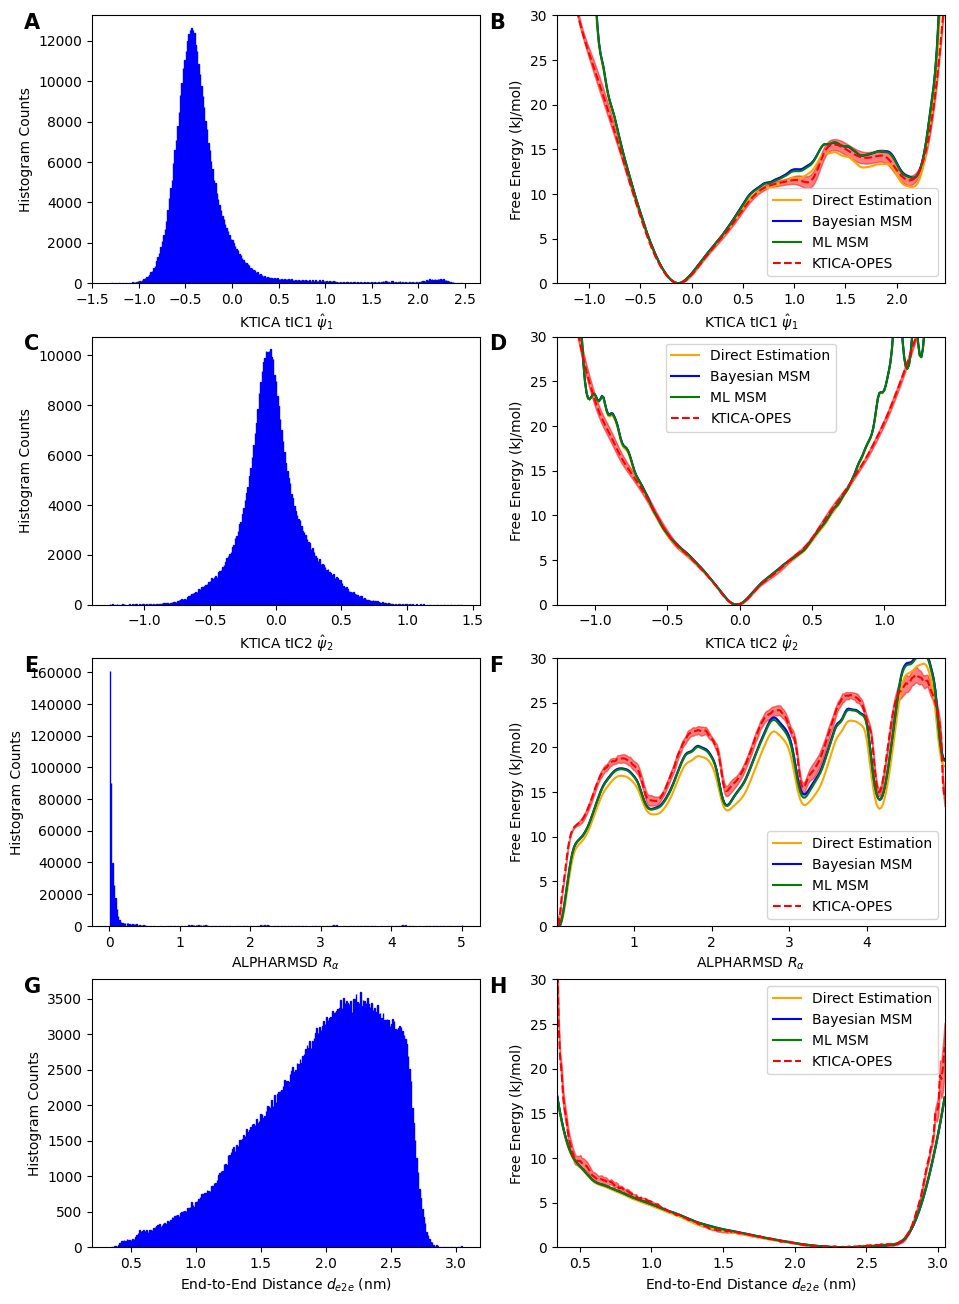

In [31]:
from scipy.stats import gaussian_kde
index_x = -0.175
index_y = 0.95


temperature = 310


msm_lagtime = 250

fig,ax = plt.subplots(nrows=4,ncols=2,figsize=(11,16))

### tIC1
# plot density first
i = 0
cv = 'tica0'

sigma = 'silverman'

x_grid = np.linspace(grid_min[i],grid_max[i],251)
histogram_count, edge = np.histogram(tica_output_concat[:,0],251)
density = histogram_count / histogram_count.sum()
ax[i,0].bar(x_grid,histogram_count,edgecolor='blue',width=0.005)
ax[i,0].set_xlabel(xlabel_name[i])
ax[i,0].set_ylabel('Histogram Counts')

# Adaptive Sampling FES without reweighting
kde = gaussian_kde(tica_output_concat[:,0],sigma)

free_energy = -8.314*temperature/1000*np.log(kde.pdf(x_grid))
free_energy = free_energy-free_energy.min()
ax[i,1].plot(x_grid,free_energy,label='Direct Estimation',color='orange')

# MSM-reweighted adaptive sampling FES

counts,msm = build_Bayesian_MSM(msm_lagtime,assignments,assignments_supp)
counts,msm_mle = build_MLE_MSM(msm_lagtime,assignments,assignments_supp)

unique_micro, count_micro = np.unique(assignments,return_counts=True)

# Bayesian MSM reweighted FES, with s.t.d. of sampled MSM as error
free_energy_all = []

for msm_i in msm.samples:
    assignments_weight_i = (msm_i.stationary_distribution / count_micro) / (msm_i.stationary_distribution / count_micro).sum()
    assignments_weights_i = dict(enumerate(assignments_weight_i))
    trajectory_weights_i = np.vectorize(assignments_weights_i.get)(assignments_concat)
    kde_i = gaussian_kde(tica_output_concat[:,0],sigma,weights=trajectory_weights_i)
    free_energy_i = -8.314*temperature/1000*np.log(kde_i.pdf(x_grid))
    free_energy_i = free_energy_i-free_energy_i.min()
    free_energy_all.append(free_energy_i)

free_energy_mean = np.mean(free_energy_all,axis=0)
free_energy_err = np.std(free_energy_all,axis=0) / np.sqrt(len(free_energy_all))

# ML MSM, without error estimation
assignments_weight = (msm_mle.stationary_distribution / count_micro) / (msm_mle.stationary_distribution / count_micro).sum()
assignments_weights = dict(enumerate(assignments_weight))
trajectory_weights = np.vectorize(assignments_weights.get)(assignments_concat)

kde = gaussian_kde(tica_output_concat[:,0],sigma,weights=trajectory_weights)
free_energy = -8.314*temperature/1000*np.log(kde.pdf(x_grid))
free_energy = free_energy-free_energy.min()

ax[i,1].plot(x_grid,free_energy_mean,label='Bayesian MSM',color='blue')
ax[i,1].fill_between(x_grid,free_energy_mean-free_energy_err, free_energy_mean+free_energy_err, color='blue', alpha=0.5)
ax[i,1].plot(x_grid,free_energy,label='ML MSM',color='green')

# Reference FES from 250ns OPES simulation
ax[i,1].plot(fes_1d[cv][cv],fes_1d[cv]['file.free'],'r--',label='KTICA-OPES')
ax[i,1].fill_between(x_grid,fes_1d[cv]['file.free']-fes_error[i], fes_1d[cv]['file.free']+fes_error[i], color='red', alpha=0.5)

ax[i,1].set_ylim(0,30)
ax[i,1].set_xlim(grid_min[i],grid_max[i])
ax[i,1].set_xlabel(xlabel_name[i])
ax[i,1].set_ylabel('Free Energy (kJ/mol)')
ax[i,1].legend()


### tIC2
# plot density first
i = 1
cv = 'tica1'

sigma = 'silverman'

x_grid = np.linspace(grid_min[i],grid_max[i],251)
histogram_count, edge = np.histogram(tica_output_concat[:,1],251)
density = histogram_count / histogram_count.sum()
ax[i,0].bar(x_grid,histogram_count,edgecolor='blue',width=0.005)
ax[i,0].set_xlabel(xlabel_name[i])
ax[i,0].set_ylabel('Histogram Counts')

# Adaptive Sampling FES without reweighting
kde = gaussian_kde(tica_output_concat[:,1],sigma)

free_energy = -8.314*temperature/1000*np.log(kde.pdf(x_grid))
free_energy = free_energy-free_energy.min()
ax[i,1].plot(x_grid,free_energy,label='Direct Estimation',color='orange')

# MSM-reweighted adaptive sampling FES

counts,msm = build_Bayesian_MSM(msm_lagtime,assignments,assignments_supp)
counts,msm_mle = build_MLE_MSM(msm_lagtime,assignments,assignments_supp)

unique_micro, count_micro = np.unique(assignments,return_counts=True)

# Bayesian MSM reweighted FES, with s.t.d. of sampled MSM as error
free_energy_all = []

for msm_i in msm.samples:
    assignments_weight_i = (msm_i.stationary_distribution / count_micro) / (msm_i.stationary_distribution / count_micro).sum()
    assignments_weights_i = dict(enumerate(assignments_weight_i))
    trajectory_weights_i = np.vectorize(assignments_weights_i.get)(assignments_concat)
    kde_i = gaussian_kde(tica_output_concat[:,1],sigma,weights=trajectory_weights_i)
    free_energy_i = -8.314*temperature/1000*np.log(kde_i.pdf(x_grid))
    free_energy_i = free_energy_i-free_energy_i.min()
    free_energy_all.append(free_energy_i)

free_energy_mean = np.mean(free_energy_all,axis=0)
free_energy_err = np.std(free_energy_all,axis=0) / np.sqrt(len(free_energy_all))

# ML MSM, without error estimation
assignments_weight = (msm_mle.stationary_distribution / count_micro) / (msm_mle.stationary_distribution / count_micro).sum()
assignments_weights = dict(enumerate(assignments_weight))
trajectory_weights = np.vectorize(assignments_weights.get)(assignments_concat)

kde = gaussian_kde(tica_output_concat[:,1],sigma,weights=trajectory_weights)
free_energy = -8.314*temperature/1000*np.log(kde.pdf(x_grid))
free_energy = free_energy-free_energy.min()

ax[i,1].plot(x_grid,free_energy_mean,label='Bayesian MSM',color='blue')
ax[i,1].fill_between(x_grid,free_energy_mean-free_energy_err, free_energy_mean+free_energy_err, color='blue', alpha=0.5)
ax[i,1].plot(x_grid,free_energy,label='ML MSM',color='green')

# Reference FES from 250ns OPES simulation
ax[i,1].plot(fes_1d[cv][cv],fes_1d[cv]['file.free'],'r--',label='KTICA-OPES')
ax[i,1].fill_between(x_grid,fes_1d[cv]['file.free']-fes_error[i], fes_1d[cv]['file.free']+fes_error[i], color='red', alpha=0.5)

ax[i,1].set_ylim(0,30)
ax[i,1].set_xlim(grid_min[i],grid_max[i])
ax[i,1].set_xlabel(xlabel_name[i])
ax[i,1].set_ylabel('Free Energy (kJ/mol)')
ax[i,1].legend()

### ALPHARMSD
# plot density first
i = 2
cv = 'alpha'

sigma = 'silverman'

x_grid = np.linspace(grid_min[i],grid_max[i],251)
histogram_count, edge = np.histogram(ref_data[cv],251)
density = histogram_count / histogram_count.sum()
ax[i,0].bar(x_grid,histogram_count,edgecolor='blue',width=0.005)
ax[i,0].set_xlabel(xlabel_name[i])
ax[i,0].set_ylabel('Histogram Counts')

# Adaptive Sampling FES without reweighting
kde = gaussian_kde(ref_data[cv],sigma)

free_energy = -8.314*temperature/1000*np.log(kde.pdf(x_grid))
free_energy = free_energy-free_energy.min()
ax[i,1].plot(x_grid,free_energy,label='Direct Estimation',color='orange')

# MSM-reweighted adaptive sampling FES

counts,msm = build_Bayesian_MSM(msm_lagtime,assignments,assignments_supp)
counts,msm_mle = build_MLE_MSM(msm_lagtime,assignments,assignments_supp)

unique_micro, count_micro = np.unique(assignments,return_counts=True)

# Bayesian MSM reweighted FES, with s.t.d. of sampled MSM as error
free_energy_all = []

for msm_i in msm.samples:
    assignments_weight_i = (msm_i.stationary_distribution / count_micro) / (msm_i.stationary_distribution / count_micro).sum()
    assignments_weights_i = dict(enumerate(assignments_weight_i))
    trajectory_weights_i = np.vectorize(assignments_weights_i.get)(assignments_concat)
    kde_i = gaussian_kde(ref_data[cv],sigma,weights=trajectory_weights_i)
    free_energy_i = -8.314*temperature/1000*np.log(kde_i.pdf(x_grid))
    free_energy_i = free_energy_i-free_energy_i.min()
    free_energy_all.append(free_energy_i)

free_energy_mean = np.mean(free_energy_all,axis=0)
free_energy_err = np.std(free_energy_all,axis=0) / np.sqrt(len(free_energy_all))

# ML MSM, without error estimation
assignments_weight = (msm_mle.stationary_distribution / count_micro) / (msm_mle.stationary_distribution / count_micro).sum()
assignments_weights = dict(enumerate(assignments_weight))
trajectory_weights = np.vectorize(assignments_weights.get)(assignments_concat)

kde = gaussian_kde(ref_data[cv],sigma,weights=trajectory_weights)
free_energy = -8.314*temperature/1000*np.log(kde.pdf(x_grid))
free_energy = free_energy-free_energy.min()

ax[i,1].plot(x_grid,free_energy_mean,label='Bayesian MSM',color='blue')
ax[i,1].fill_between(x_grid,free_energy_mean-free_energy_err, free_energy_mean+free_energy_err, color='blue', alpha=0.5)
ax[i,1].plot(x_grid,free_energy,label='ML MSM',color='green')

# Reference FES from 250ns OPES simulation
ax[i,1].plot(fes_1d[cv][cv],fes_1d[cv]['file.free'],'r--',label='KTICA-OPES')
ax[i,1].fill_between(x_grid,fes_1d[cv]['file.free']-fes_error[i], fes_1d[cv]['file.free']+fes_error[i], color='red', alpha=0.5)

ax[i,1].set_ylim(0,30)
ax[i,1].set_xlim(grid_min[i],grid_max[i])
ax[i,1].set_xlabel(xlabel_name[i])
ax[i,1].set_ylabel('Free Energy (kJ/mol)')
ax[i,1].legend()

### ALPHARMSD
# plot density first
i = 3
cv = 'e2e'

sigma = 'silverman'

x_grid = np.linspace(grid_min[i],grid_max[i],251)
histogram_count, edge = np.histogram(ref_data[cv],251)
density = histogram_count / histogram_count.sum()
ax[i,0].bar(x_grid,histogram_count,edgecolor='blue',width=0.005)
ax[i,0].set_xlabel(xlabel_name[i])
ax[i,0].set_ylabel('Histogram Counts')

# Adaptive Sampling FES without reweighting
kde = gaussian_kde(ref_data[cv],sigma)

free_energy = -8.314*temperature/1000*np.log(kde.pdf(x_grid))
free_energy = free_energy-free_energy.min()
ax[i,1].plot(x_grid,free_energy,label='Direct Estimation',color='orange')

# MSM-reweighted adaptive sampling FES

counts,msm = build_Bayesian_MSM(msm_lagtime,assignments,assignments_supp)
counts,msm_mle = build_MLE_MSM(msm_lagtime,assignments,assignments_supp)

unique_micro, count_micro = np.unique(assignments,return_counts=True)

# Bayesian MSM reweighted FES, with s.t.d. of sampled MSM as error
free_energy_all = []

for msm_i in msm.samples:
    assignments_weight_i = (msm_i.stationary_distribution / count_micro) / (msm_i.stationary_distribution / count_micro).sum()
    assignments_weights_i = dict(enumerate(assignments_weight_i))
    trajectory_weights_i = np.vectorize(assignments_weights_i.get)(assignments_concat)
    kde_i = gaussian_kde(ref_data[cv],sigma,weights=trajectory_weights_i)
    free_energy_i = -8.314*temperature/1000*np.log(kde_i.pdf(x_grid))
    free_energy_i = free_energy_i-free_energy_i.min()
    free_energy_all.append(free_energy_i)

free_energy_mean = np.mean(free_energy_all,axis=0)
free_energy_err = np.std(free_energy_all,axis=0) / np.sqrt(len(free_energy_all))

# ML MSM, without error estimation
assignments_weight = (msm_mle.stationary_distribution / count_micro) / (msm_mle.stationary_distribution / count_micro).sum()
assignments_weights = dict(enumerate(assignments_weight))
trajectory_weights = np.vectorize(assignments_weights.get)(assignments_concat)

kde = gaussian_kde(ref_data[cv],sigma,weights=trajectory_weights)
free_energy = -8.314*temperature/1000*np.log(kde.pdf(x_grid))
free_energy = free_energy-free_energy.min()

ax[i,1].plot(x_grid,free_energy_mean,label='Bayesian MSM',color='blue')
ax[i,1].fill_between(x_grid,free_energy_mean-free_energy_err, free_energy_mean+free_energy_err, color='blue', alpha=0.5)
ax[i,1].plot(x_grid,free_energy,label='ML MSM',color='green')

# Reference FES from 250ns OPES simulation
ax[i,1].plot(fes_1d[cv][cv],fes_1d[cv]['file.free'],'r--',label='KTICA-OPES')
ax[i,1].fill_between(x_grid,fes_1d[cv]['file.free']-fes_error[i], fes_1d[cv]['file.free']+fes_error[i], color='red', alpha=0.5)

ax[i,1].set_ylim(0,30)
ax[i,1].set_xlim(grid_min[i],grid_max[i])
ax[i,1].set_xlabel(xlabel_name[i])
ax[i,1].set_ylabel('Free Energy (kJ/mol)')
ax[i,1].legend()

ax[0,0].text(index_x, index_y, string.ascii_uppercase[0],transform=ax[0,0].transAxes, size=15, weight='bold')
ax[0,1].text(index_x, index_y, string.ascii_uppercase[1],transform=ax[0,1].transAxes, size=15, weight='bold')
ax[1,0].text(index_x, index_y, string.ascii_uppercase[2],transform=ax[1,0].transAxes, size=15, weight='bold')
ax[1,1].text(index_x, index_y, string.ascii_uppercase[3],transform=ax[1,1].transAxes, size=15, weight='bold')
ax[2,0].text(index_x, index_y, string.ascii_uppercase[4],transform=ax[2,0].transAxes, size=15, weight='bold')
ax[2,1].text(index_x, index_y, string.ascii_uppercase[5],transform=ax[2,1].transAxes, size=15, weight='bold')
ax[3,0].text(index_x, index_y, string.ascii_uppercase[6],transform=ax[3,0].transAxes, size=15, weight='bold')
ax[3,1].text(index_x, index_y, string.ascii_uppercase[7],transform=ax[3,1].transAxes, size=15, weight='bold')

plt.savefig('figures/adaptive_sampling_FES50ns.png',dpi=600)

plt.show()

In [32]:
# Write new features set which also includes side chain info (CB-CB distances)
u = md.Universe('traj_and_dat/input.pdb')
ca = u.select_atoms('name CA')
cb = u.select_atoms('name CB')
ca_ids = list(ca.ids)
cb_ids = list(cb.ids)
atom_pairs = list(itertools.combinations(ca_ids, 2)) + list(itertools.combinations(cb_ids, 2))

dihedrals = select_dihedrals(u,['phi','psi'],2,9)

# Write features into plumed file
with open('traj_and_dat/features_test.dat','w+') as f:
    f.writelines('MOLINFO STRUCTURE=traj_and_dat/input.pdb\n')
    
    count = 0
    for pair in atom_pairs:
        atom1 = pair[0]
        atom2 = pair[1]
        count = count + 1
        f.writelines('pair{count}: DISTANCE ATOMS={atom1},{atom2}\n'.format(count=count,atom1=atom1,atom2=atom2))
        
    f.writelines('psi-1: TORSION ATOMS=@psi-1\n')
    f.writelines('sinpsi-1: CUSTOM ARG=psi-1 FUNC=sin(x) PERIODIC=NO\n')
    f.writelines('cospsi-1: CUSTOM ARG=psi-1 FUNC=cos(x) PERIODIC=NO\n')
    for dihedral in dihedrals:
        for resid in dihedrals[dihedral]:
            f.writelines('{dihedral}-{resid}: TORSION ATOMS=@{dihedral}-{resid}\n'.format(dihedral=dihedral,resid=resid))
            f.writelines('sin{dihedral}-{resid}: CUSTOM ARG={dihedral}-{resid} FUNC=sin(x) PERIODIC=NO\n'.format(dihedral=dihedral,resid=resid))
            f.writelines('cos{dihedral}-{resid}: CUSTOM ARG={dihedral}-{resid} FUNC=cos(x) PERIODIC=NO\n'.format(dihedral=dihedral,resid=resid))
        f.writelines('\n')
    f.writelines('phi-10: TORSION ATOMS=@phi-10\n')
    f.writelines('sinphi-10: CUSTOM ARG=phi-10 FUNC=sin(x) PERIODIC=NO\n')
    f.writelines('cosphi-10: CUSTOM ARG=phi-10 FUNC=cos(x) PERIODIC=NO\n')
    f.writelines('PRINT ARG=* STRIDE=1 FILE=COLVAR')

In [33]:
# Read features
# traj is the time-series COLVAR in pandas.DataFrame format
sim_idx = 11
colvar = 'CV_test/COLVAR'

traj_cb = [0]*sim_idx*n_sim

for i in range(sim_idx*n_sim):
    traj_cb[i] = plumed.read_as_pandas(colvar+'_{i}'.format(i=i))
    traj_cb[i] = traj_cb[i].drop(columns=['time'])
    columns = list(traj_cb[i].columns.values)
    # Remove all dihedral angles, only keep sin/cos dihedrals 
    for column in columns:
        if column[:3] == 'phi' or column[:3] == 'psi' or column[:3] == 'chi' or column[:5] == 'omega':
            traj_cb[i] = traj_cb[i].drop(columns=[column])
        
# data is the time-series COLVAR in numpy.ndarrays format
data_cb = [0]*len(traj_cb)
for i in range(len(traj_cb)):
    data_cb[i] = traj_cb[i].to_numpy(dtype='float32')

data_supp_cb = data_supplement(sim_idx,data_cb,tica_lagtime)
tica_cb = run_TICA(data_cb,data_supp_cb,tica_lagtime,dim,var_cutoff,koopman)[0]

# Read original features
colvar = 'CV/COLVAR'

traj,data = read_features(colvar,sim_idx,n_sim)
data_supp = data_supplement(sim_idx,data,tica_lagtime)
tica = run_TICA(data,data_supp,tica_lagtime,dim,var_cutoff,koopman)[0]

# Remove dihedrals
for i in range(sim_idx*n_sim):
    columns = list(traj[i].columns.values)
    # Remove all dihedral angles, only keep sin/cos dihedrals 
    for column in columns:
        if column[:3] == 'sin' or column[:3] == 'cos':
            traj[i] = traj[i].drop(columns=[column])
            
data_ca = [0]*len(traj)
for i in range(len(traj)):
    data_ca[i] = traj[i].to_numpy(dtype='float32')

data_supp_ca = data_supplement(sim_idx,data_ca,tica_lagtime)
tica_ca = run_TICA(data_ca,data_supp_ca,tica_lagtime,dim,var_cutoff,koopman)[0]

In [34]:
data_cb[0].shape,data[0].shape,data_ca[0].shape

((501, 126), (501, 81), (501, 45))

In [35]:
# Calculate kinetic content
ca_kc = ((tica_ca.singular_values[:2])**2).sum()/((tica_ca.singular_values[:5])**2).sum()
kc = ((tica.singular_values[:2])**2).sum()/((tica.singular_values[:5])**2).sum()
cb_kc = ((tica_cb.singular_values[:2])**2).sum()/((tica_cb.singular_values[:5])**2).sum()
ca_kc,kc,cb_kc

(0.7540324541834823, 0.6592736925896572, 0.6367563732566743)

In [36]:
# Calculate kinetic content
ca_kc = ((tica_ca.singular_values[:2])**2).sum()/((tica_ca.singular_values)**2).sum()
kc = ((tica.singular_values[:2])**2).sum()/((tica.singular_values)**2).sum()
cb_kc = ((tica_cb.singular_values[:2])**2).sum()/((tica_cb.singular_values)**2).sum()
ca_kc,kc,cb_kc

(0.5316641501305368, 0.3614344501703273, 0.2691588716761883)

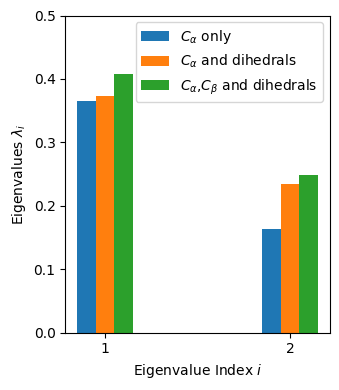

In [37]:
# Plot eigenvalues of tIC1 and tIC2
fig,ax = plt.subplots(figsize=(3.5,4))
width = 0.1
n_eigenvalues = 2

label = [r'$C_\alpha$ only',r'$C_\alpha$ and dihedrals',r'$C_\alpha$,$C_\beta$ and dihedrals']

x_ticks = np.linspace(1,n_eigenvalues,n_eigenvalues)
x = x_ticks - len(label)/2 * width + 0.5* width

x_labels = [1,2,'kinetic variance']
ax.bar(x,tica_ca.singular_values[:2],label=label[0],width=width)
x = x + width
ax.bar(x,tica.singular_values[:2],label=label[1],width=width)
x = x + width
ax.bar(x,tica_cb.singular_values[:2],label=label[2],width=width)
ax.set_xticks(x_ticks)
ax.set_ylim(0,0.5)
ax.legend()
ax.set_xlabel('Eigenvalue Index $i$')
ax.set_ylabel('Eigenvalues $\lambda_i$')

plt.tight_layout()
plt.savefig('figures/eigenvalues_features.png',dpi=600)

plt.show()

In [38]:
traj,data = read_features(colvar,sim_idx,n_sim)

u = md.Universe('traj_and_dat/input.pdb')
heavy_atom = u.select_atoms('name CA')
ids = list(heavy_atom.ids)
atom_pairs = list(itertools.combinations(ids, 2))

In [39]:
feature_labels = []
for pair in atom_pairs:
    id1,id2 = pair
    resid1 = u.atoms[id1-1].resid
    resid2 = u.atoms[id2-1].resid
    if resid2 == 10:
        feature_label_i = r'$C_\alpha^{resid1}$-$C_\alpha^{{{resid2}}}$'.format(resid1=resid1,resid2=resid2)
    else:
        feature_label_i = r'$C_\alpha^{resid1}$-$C_\alpha^{resid2}$'.format(resid1=resid1,resid2=resid2)
    feature_labels.append(feature_label_i)

feature_labels += list(traj[0].columns.values)[len(atom_pairs):]

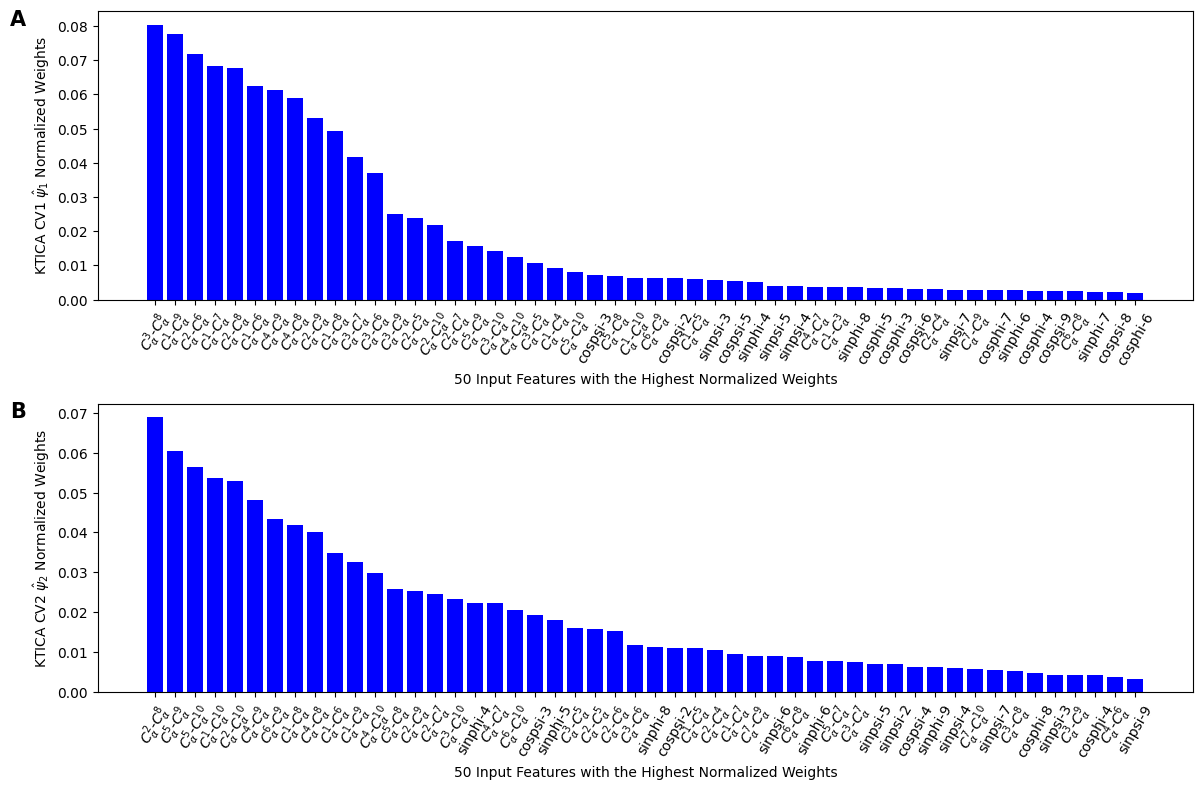

In [40]:
# Final KTICA descriptor ranking
### Descriptor weight analysis

# Retrieve our feature selection
u = md.Universe('traj_and_dat/input.pdb')
heavy_atom = u.select_atoms('name CA')
ids = list(heavy_atom.ids)
atom_pairs = list(itertools.combinations(ids, 2))

# Retrieve feature labels
columns = list(traj[0].columns.values)

# Plot weight analysis
index_x = -0.08
index_y = 0.95

fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(12,8))

n_features_shown = 50

i = 0

weights = np.abs(tica.singular_vectors_left.T[i])*np.concatenate(np.array(data)).std(axis=0)

x_labels = []
for j in np.argsort(weights)[:-n_features_shown-1:-1]:
    x_labels.append(feature_labels[j])

x = np.linspace(1,len(tica.singular_vectors_left.T[i][:n_features_shown]),len(tica.singular_vectors_left.T[i][:n_features_shown]))
weights_sort = weights[np.argsort(weights)][:-n_features_shown-1:-1]
normalized_weights = weights_sort/weights_sort.sum()

for k,normalized_weights_k in enumerate(normalized_weights):
    ax[i].bar(x[k],normalized_weights[k],align='center',color='blue')
        
ax[i].set_xticks(x,x_labels,rotation=60)
ax[i].set_xlabel('{n_features_shown} Input Features with the Highest Normalized Weights'.format(n_features_shown=n_features_shown))
ax[i].set_ylabel('KTICA CV1 $\hat \psi_1$ Normalized Weights')

i = 1

weights = np.abs(tica.singular_vectors_left.T[i])*np.concatenate(np.array(data)).std(axis=0)

x_labels = []
for j in np.argsort(weights)[:-n_features_shown-1:-1]:
    x_labels.append(feature_labels[j])

x = np.linspace(1,len(tica.singular_vectors_left.T[i][:n_features_shown]),len(tica.singular_vectors_left.T[i][:n_features_shown]))
weights_sort = weights[np.argsort(weights)][:-n_features_shown-1:-1]
normalized_weights = weights_sort/weights_sort.sum()

for k,normalized_weights_k in enumerate(normalized_weights):
    ax[i].bar(x[k],normalized_weights[k],align='center',color='blue')
        
ax[i].set_xticks(x,x_labels,rotation=60)
ax[i].set_xlabel('{n_features_shown} Input Features with the Highest Normalized Weights'.format(n_features_shown=n_features_shown))
ax[i].set_ylabel('KTICA CV2 $\hat \psi_2$ Normalized Weights')

ax[0].text(index_x, index_y, string.ascii_uppercase[0],transform=ax[0].transAxes, size=15, weight='bold')
ax[1].text(index_x, index_y, string.ascii_uppercase[1],transform=ax[1].transAxes, size=15, weight='bold')

plt.tight_layout()
plt.savefig('figures/tic_weights.png',dpi=600,bbox_inches='tight')
plt.show()

In [41]:
colvar = 'CV_test/COLVAR'
traj,data = read_features(colvar,sim_idx,n_sim)

u = md.Universe('traj_and_dat/input.pdb')
ca = u.select_atoms('name CA')
cb = u.select_atoms('name CB')
ca_ids = list(ca.ids)
cb_ids = list(cb.ids)
atom_pairs = list(itertools.combinations(ca_ids, 2)) + list(itertools.combinations(cb_ids, 2))

feature_labels = []
for i,pair in enumerate(atom_pairs):
    id1,id2 = pair
    resid1 = u.atoms[id1-1].resid
    resid2 = u.atoms[id2-1].resid
    if i < len(list(itertools.combinations(ca_ids, 2))):
        feature_label_i = r'$C_\alpha^{resid1}$-$C_\alpha^{{{resid2}}}$'.format(resid1=resid1,resid2=resid2)
    else:
        feature_label_i = r'$C_\beta^{resid1}$-$C_\beta^{{{resid2}}}$'.format(resid1=resid1,resid2=resid2)
    feature_labels.append(feature_label_i)

feature_labels += list(traj[0].columns.values)[len(atom_pairs):]

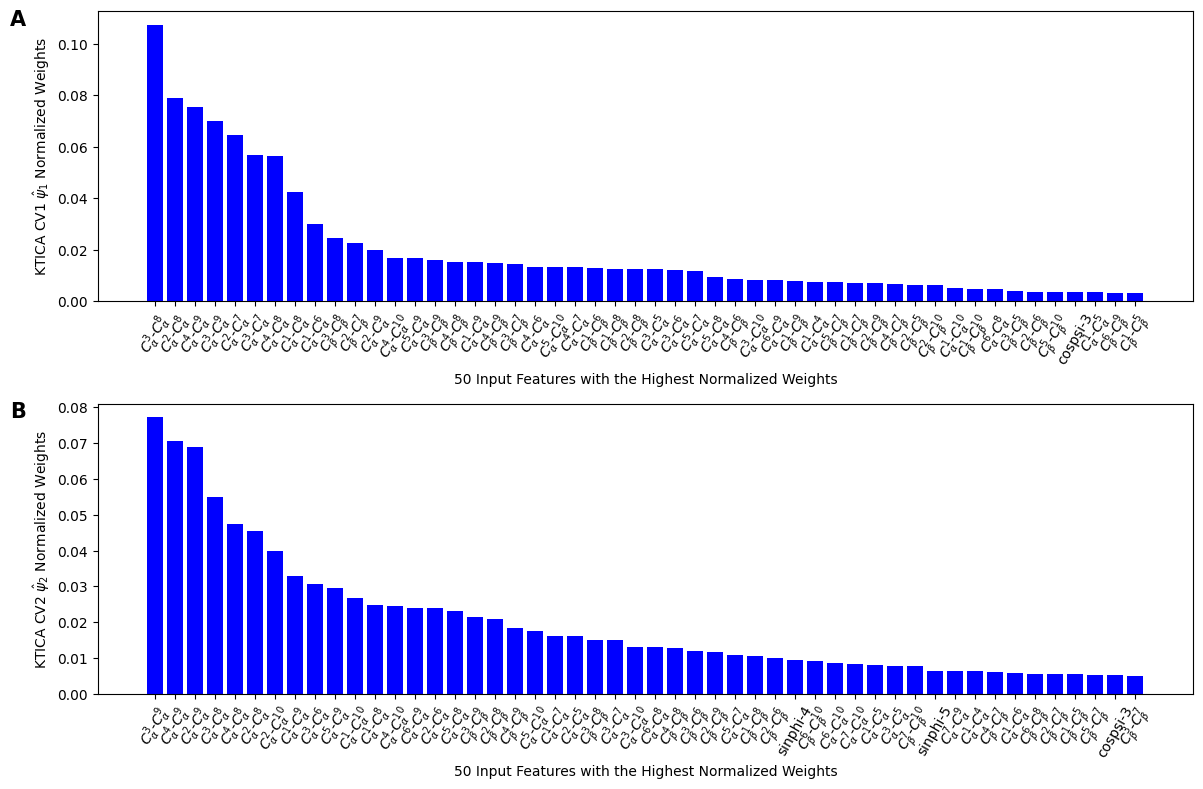

In [42]:
fig,ax = plt.subplots(nrows=2,ncols=1,figsize=(12,8))

n_features_shown = 50

i = 0

weights = np.abs(tica_cb.singular_vectors_left.T[i])*np.concatenate(np.array(data)).std(axis=0)

x_labels = []
for j in np.argsort(weights)[:-n_features_shown-1:-1]:
    x_labels.append(feature_labels[j])

x = np.linspace(1,len(tica_cb.singular_vectors_left.T[i][:n_features_shown]),len(tica_cb.singular_vectors_left.T[i][:n_features_shown]))
weights_sort = weights[np.argsort(weights)][:-n_features_shown-1:-1]
normalized_weights = weights_sort/weights_sort.sum()

for k,normalized_weights_k in enumerate(normalized_weights):
    ax[i].bar(x[k],normalized_weights[k],align='center',color='blue')
        
ax[i].set_xticks(x,x_labels,rotation=60)
ax[i].set_xlabel('{n_features_shown} Input Features with the Highest Normalized Weights'.format(n_features_shown=n_features_shown))
ax[i].set_ylabel('KTICA CV1 $\hat \psi_1$ Normalized Weights')

i = 1

weights = np.abs(tica_cb.singular_vectors_left.T[i])*np.concatenate(np.array(data)).std(axis=0)

x_labels = []
for j in np.argsort(weights)[:-n_features_shown-1:-1]:
    x_labels.append(feature_labels[j])

x = np.linspace(1,len(tica_cb.singular_vectors_left.T[i][:n_features_shown]),len(tica_cb.singular_vectors_left.T[i][:n_features_shown]))
weights_sort = weights[np.argsort(weights)][:-n_features_shown-1:-1]
normalized_weights = weights_sort/weights_sort.sum()

for k,normalized_weights_k in enumerate(normalized_weights):
    ax[i].bar(x[k],normalized_weights[k],align='center',color='blue')
        
ax[i].set_xticks(x,x_labels,rotation=60)
ax[i].set_xlabel('{n_features_shown} Input Features with the Highest Normalized Weights'.format(n_features_shown=n_features_shown))
ax[i].set_ylabel('KTICA CV2 $\hat \psi_2$ Normalized Weights')

ax[0].text(index_x, index_y, string.ascii_uppercase[0],transform=ax[0].transAxes, size=15, weight='bold')
ax[1].text(index_x, index_y, string.ascii_uppercase[1],transform=ax[1].transAxes, size=15, weight='bold')

plt.tight_layout()
plt.savefig('figures/tic_weights_cb.png',dpi=600,bbox_inches='tight')
plt.show()